# Model Monitor with BYO XGBoost Containers (SDK v2)

In this notebook, we will walk through how to build your own custom XGBoost Container and set up Model Monitoring on the deployed endpoint. We will also demonstrate, how to use SageMaker Processing to build a custom data processing pipeline, and use SageMaker Debugger to create custom rules that monitor your model during training.

### Download and import necessary libraries

In [1]:
!pip install --upgrade sagemaker
!pip install --upgrade pip
!pip install sagemaker-experiments 
#!pip install smdebug
!pip install boto3 --upgrade
!pip install xgboost==0.90

     |████████████████████████████████| 306 kB 12.0 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.16.1-py2.py3-none-any.whl size=435538 sha256=7b14f6fa86548a727f329dd4de8c20d5764ce38fcf37a53076f4cc5607abf8b9
  Stored in directory: /root/.cache/pip/wheels/51/55/2e/4d1084844748da709993491bfa75892fb23388b66537c53f0b
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.15.2
    Uninstalling sagemaker-2.15.2:
      Successfully uninstalled sagemaker-2.15.2
     |████████████████████████████████| 1.5 MB 10.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |████████████████████████████████| 97 kB 672 kB/s  eta 0:00:01
     |████████████████████████████████| 6.7 MB 20.6 MB/s eta 0:00:01
  Created wheel for boto3: filename=boto3-1.16.10-py2.py3-none-any.whl size=128452 sha256=f90bd057b3f4388ed37bda7075e

### Restart Kernel

Once the libraries are installed, restart the kernel by clicking Kernel --> Restart and Running all the cells below.

In [1]:
# Let's inspect the role we have created for our notebook here:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.session.Session().region_name
print("Region = {}".format(region))
sm = boto3.Session().client('sagemaker')

Region = us-east-1


### Complete Setup: Import libraries and set global definitions.

All needed libraries will come pre-installed with this notebook with the Lifecycle configuration scripts.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import sleep, gmtime, strftime
import json
import time

In [3]:
# Import SageMaker Experiments 

from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

### Specify buckets for storing data

In [4]:
# Use our custom bucket here. 
rawbucket= sess.default_bucket()
prefix = 'sagemaker-modelmonitor-stefan' # use this prefix to store all files pertaining to this workshop.

dataprefix = prefix + '/data'
traindataprefix = prefix + '/train_data'
testdataprefix = prefix + '/test_data'
testdatanolabelprefix = prefix + '/test_data_no_label'
trainheaderprefix = prefix + '/train_headers'

# Pre-processing and Feature Engineering

A key part of the data science lifecyle is data exploration, pre-processing and feature engineering. We will demonstrate how to use SM notebooks for data exploration and SM Processing for feature engineering and pre-processing data

### Download and Import the data

In [6]:
data = pd.read_excel('./credit_card_default_data.xls', header=1)
data = data.drop(columns = ['ID'])
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# Note that the categorical columns SEX, Education and Marriage have been Integer Encoded in this case.
# For example:
data.SEX.value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [8]:
data.rename(columns={"default payment next month": "Label"}, inplace=True)
lbl = data.Label
data = pd.concat([lbl, data.drop(columns=['Label'])], axis = 1)
data.head()

,Label,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,1,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


### Data Exploration

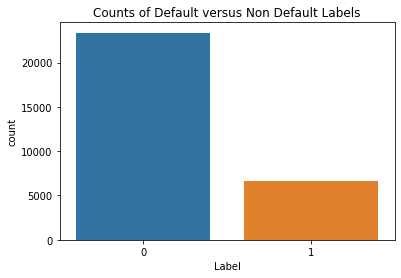

In [9]:
import seaborn as sns
sns.countplot(data.Label)
plt.title('Counts of Default versus Non Default Labels')
plt.show()

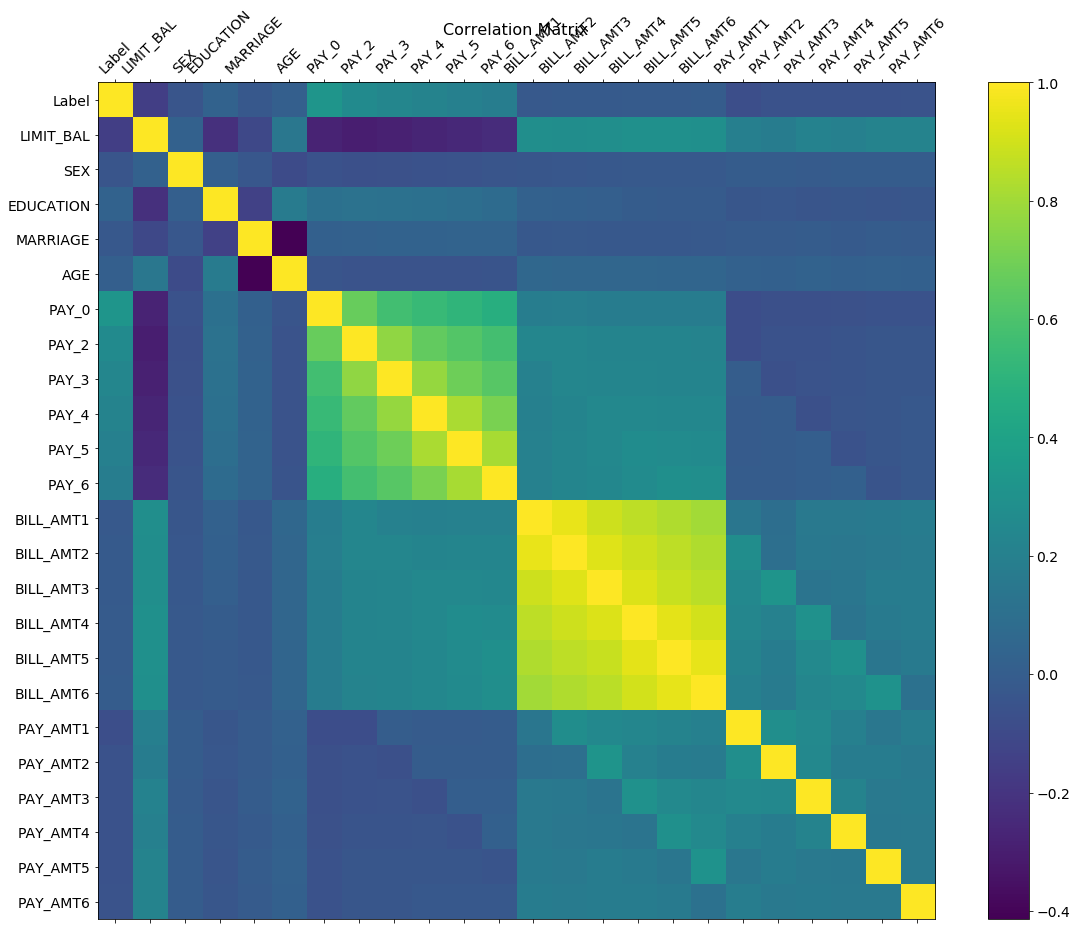

In [10]:
## Corr plot
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

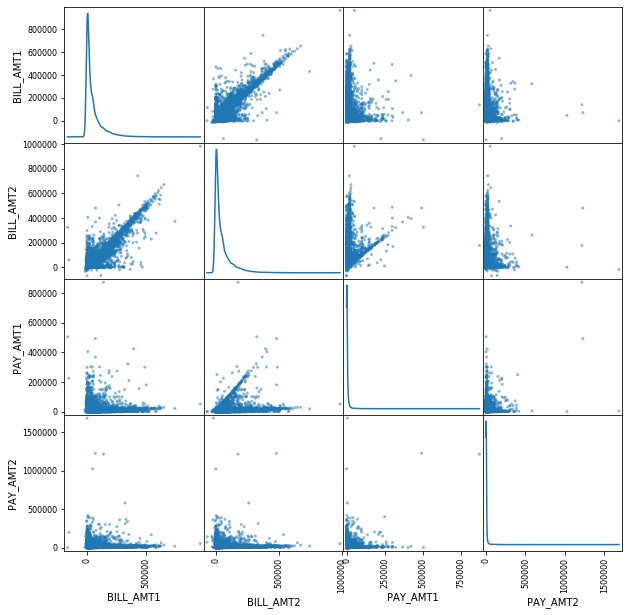

In [11]:
from pandas.plotting import scatter_matrix
SCAT_COLUMNS = ['BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2']
scatter_matrix(data[SCAT_COLUMNS],figsize=(10, 10), diagonal ='kde')
plt.show()

### Preprocessing and Feature Engineering in Notebook

In [12]:
if not os.path.exists('rawdata/rawdata.csv'):
    !mkdir ./rawdata
    data.to_csv('rawdata/rawdata.csv', index=None)
else:
    pass

In [13]:
# Upload the raw dataset
raw_data_location = sess.upload_data('rawdata', bucket=rawbucket, key_prefix=dataprefix)
print(raw_data_location)

s3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/data


In [14]:
# Run the preprocessing job in the notebook and upload the training and validation datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

COLS = data.columns
X_train, X_test, y_train, y_test = train_test_split(data.drop('Label', axis=1), data['Label'], 
                                                       test_size=0.2, random_state=0)

newcolorder = ['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]

preprocess = make_column_transformer(
        (StandardScaler(), ['PAY_AMT1']),
        (MinMaxScaler(),['BILL_AMT1']),
    remainder='passthrough')
    
print('Running preprocessing and feature engineering transformations')
train_features = pd.DataFrame(preprocess.fit_transform(X_train), columns = newcolorder)
test_features = pd.DataFrame(preprocess.transform(X_test), columns = newcolorder)

train_full = pd.concat([pd.DataFrame(y_train.values, columns=['Label']), pd.DataFrame(train_features)], axis=1)
test_full = pd.concat([pd.DataFrame(y_test.values, columns=['Label']), pd.DataFrame(test_features)], axis=1)
train_full.to_csv('train_data.csv', index=False, header=False)
test_full.to_csv('test_data.csv', index=False, header=False)                                                   
train_full.to_csv('train_data_with_headers.csv', index=False)                                                    

Running preprocessing and feature engineering transformations


In [15]:
# Upload data
train_data_location = sess.upload_data('train_data_with_headers.csv', bucket=rawbucket, key_prefix=trainheaderprefix)
train_data_location = sess.upload_data('train_data.csv', bucket=rawbucket, key_prefix=traindataprefix)
test_data_location = sess.upload_data('test_data.csv', bucket=rawbucket, key_prefix=testdataprefix)

### Secure Feature Processing pipeline using SageMaker Processing

While you can pre-process small amounts of data directly in a notebook as shown above, SageMaker Processing offloads the heavy lifting of pre-processing larger datasets by provisioning the underlying infrastructure, downloading the data from an S3 location to the processing container, running the processing scripts, storing the processed data in an output directory in Amazon S3 and deleting the underlying transient resources needed to run the processing job. Once the processing job is complete, the infrastructure used to run the job is wiped, and any temporary data stored on it is deleted.

In [16]:
## Use SageMaker Processing with Sk Learn. -- combine data into train and test at this stage if possible.
from sagemaker.sklearn.processing import SKLearnProcessor
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.c4.xlarge',
                                     instance_count=1) 

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


### Write a preprocessing script (same as above)

In [17]:
%%writefile preprocessing.py

import argparse
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.compose import make_column_transformer

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train-test-split-ratio', type=float, default=0.3)
    parser.add_argument('--random-split', type=int, default=0)
    args, _ = parser.parse_known_args()
    
    print('Received arguments {}'.format(args))

    input_data_path = os.path.join('/opt/ml/processing/input', 'rawdata.csv')
    
    print('Reading input data from {}'.format(input_data_path))
    df = pd.read_csv(input_data_path)
    df.sample(frac=1)
    
    COLS = df.columns
    newcolorder = ['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
    
    split_ratio = args.train_test_split_ratio
    random_state=args.random_split
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop('Label', axis=1), df['Label'], 
                                                        test_size=split_ratio, random_state=random_state)
    
    preprocess = make_column_transformer(
        (['PAY_AMT1'], StandardScaler()),
        (['BILL_AMT1'], MinMaxScaler()),
    remainder='passthrough')
    
    print('Running preprocessing and feature engineering transformations')
    train_features = pd.DataFrame(preprocess.fit_transform(X_train), columns = newcolorder)
    test_features = pd.DataFrame(preprocess.transform(X_test), columns = newcolorder)
    
    # concat to ensure Label column is the first column in dataframe
    train_full = pd.concat([pd.DataFrame(y_train.values, columns=['Label']), train_features], axis=1)
    test_full = pd.concat([pd.DataFrame(y_test.values, columns=['Label']), test_features], axis=1)
    
    print('Train data shape after preprocessing: {}'.format(train_features.shape))
    print('Test data shape after preprocessing: {}'.format(test_features.shape))
    
    train_features_headers_output_path = os.path.join('/opt/ml/processing/train_headers', 'train_data_with_headers.csv')
    
    train_features_output_path = os.path.join('/opt/ml/processing/train', 'train_data.csv')
    
    test_features_output_path = os.path.join('/opt/ml/processing/test', 'test_data.csv')
    
    print('Saving training features to {}'.format(train_features_output_path))
    train_full.to_csv(train_features_output_path, header=False, index=False)
    print("Complete")
    
    print("Save training data with headers to {}".format(train_features_headers_output_path))
    train_full.to_csv(train_features_headers_output_path, index=False)
                 
    print('Saving test features to {}'.format(test_features_output_path))
    test_full.to_csv(test_features_output_path, header=False, index=False)
    print("Complete")
    

Writing preprocessing.py


In [18]:
# Copy the preprocessing code over to the s3 bucket
codeprefix = prefix + '/code'
codeupload = sess.upload_data('preprocessing.py', bucket=rawbucket, key_prefix=codeprefix)
print(codeupload)

s3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/code/preprocessing.py


In [19]:
train_data_location = rawbucket + '/' + traindataprefix
test_data_location = rawbucket+'/'+testdataprefix
print("Training data location = {}".format(train_data_location))
print("Test data location = {}".format(test_data_location))

Training data location = sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/train_data
Test data location = sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/test_data


In [20]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(code=codeupload,
                      inputs=[ProcessingInput(
                        source=raw_data_location,
                        destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train_data',
                                                source='/opt/ml/processing/train',
                               destination='s3://' + train_data_location),
                               ProcessingOutput(output_name='test_data',
                                                source='/opt/ml/processing/test',
                                               destination="s3://"+test_data_location),
                               ProcessingOutput(output_name='train_data_headers',
                                                source='/opt/ml/processing/train_headers',
                                               destination="s3://" + rawbucket + '/' + prefix + '/train_headers')],
                      arguments=['--train-test-split-ratio', '0.2']
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'train_data':
        preprocessed_training_data = output['S3Output']['S3Uri']
    if output['OutputName'] == 'test_data':
        preprocessed_test_data = output['S3Output']['S3Uri']

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2020-11-03-20-55-52-043



Job Name:  sagemaker-scikit-learn-2020-11-03-20-55-52-043
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/data', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/train_data', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'test_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/te

# Model development and Training

## Traceability and Auditability 

We use SageMaker Experiments for data scientists to track the lineage of the model from the raw data source to the preprocessing steps and the model training pipeline. With SageMaker Experiments, data scientists can compare, track and manage multiple diferent model training jobs, data processing jobs, hyperparameter tuning jobs and retain a lineage from the source data to the training job artifacts to the model hyperparameters and any custom metrics that they may want to monitor as part of the model training.

As we demonstrate here, SageMaker Experiments works with Bring-Your-Own-Container in addition to SageMaker algorithms. 

In [21]:
# Create a SageMaker Experiment
cc_experiment = Experiment.create(
    experiment_name=f"Studio-Webinar-Demo-{int(time.time())}", 
    description="Predict credit card default from payments data", 
    sagemaker_boto_client=sm)
print(cc_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f5b27de6550>,experiment_name='Studio-Webinar-Demo-1604437389',description='Predict credit card default from payments data',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:544194174732:experiment/studio-webinar-demo-1604437389',response_metadata={'RequestId': 'd231c5f6-d1d7-4c77-a8db-e84403fab679', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'd231c5f6-d1d7-4c77-a8db-e84403fab679', 'content-type': 'application/x-amz-json-1.1', 'content-length': '102', 'date': 'Tue, 03 Nov 2020 21:03:09 GMT'}, 'RetryAttempts': 0})


In [22]:
# Start Tracking parameters used in the Pre-processing pipeline.
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "train_test_split_ratio": 0.2,
        "random_state":0
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="ccdefault-raw-dataset", media_type="s3/uri", value=raw_data_location)
    tracker.log_input(name="ccdefault-train-dataset", media_type="s3/uri", value=train_data_location)
    tracker.log_input(name="ccdefault-test-dataset", media_type="s3/uri", value=test_data_location)  

### Build XgBoost container for training

The code for the XGB container is already supplied with this notebook. We simply need to build this container and push it to ECR. 

### Train the Model

The same security postures we applied previously during SM Processing apply to training jobs. We will also have SageMaker experiments track the training job and store metadata such as model artifact location, training/validation data location, model hyperparameters etc.


In [23]:


image = sagemaker.image_uris.retrieve(framework='xgboost', version='0.90-1', region = boto3.Session().region_name) #path to your ECR docker file

preprocessing_trial_component = tracker.trial_component

trial_name = f"cc-fraud-training-job-{int(time.time())}"
cc_trial = Trial.create(
        trial_name=trial_name, 
            experiment_name=cc_experiment.experiment_name,
        sagemaker_boto_client=sm
    )

cc_trial.add_trial_component(preprocessing_trial_component)
cc_training_job_name = "cc-training-job-{}".format(int(time.time()))

xgb = sagemaker.estimator.Estimator(image,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    max_run=86400,
                                    output_path='s3://{}/{}/models'.format(rawbucket, prefix),
                                    sagemaker_session=sess) # set to true for distributed training

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        verbosity=0,
                        objective='binary:logistic',
                        num_round=100)

s3_input_train = sagemaker.session.s3_input(s3_data=f's3://{rawbucket}/{prefix}/train_data/train_data.csv', content_type='csv')
#s3_input_test = sagemaker.s3_input(s3_data='s3://sagemaker-workshop-cloudformation-{}/test_data.csv'.format (region), content_type='csv')

#xgb.fit(inputs = {'training':"s3://" + train_data_location},
xgb.fit(inputs = {'train': s3_input_train}, #"s3://" + train_data_location},
       job_name=cc_training_job_name,
        experiment_config={
            "TrialName": cc_trial.trial_name, #log training job in Trials for lineage
            "TrialComponentDisplayName": "Train", #"Training",
        },
        wait=True,
    )
time.sleep(2)


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: cc-training-job-1604438997


2020-11-03 21:29:57 Starting - Starting the training job...
2020-11-03 21:29:59 Starting - Launching requested ML instances......
2020-11-03 21:31:15 Starting - Preparing the instances for training......
2020-11-03 21:32:26 Downloading - Downloading input data......
2020-11-03 21:33:13 Training - Downloading the training image...
2020-11-03 21:33:58 Uploading - Uploading generated training model
2020-11-03 21:33:58 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[21:33:43] 24000x23 matrix with 552000 entries loaded from /opt/ml/input/data/

##  5. Traceability and Auditability from source control to Model artifacts

Having used SageMaker Experiments to track the training runs, we can now extract model metadata to get the entire lineage of the model from the source data to the model artifacts and the hyperparameters.

To do this, simply call the **describe_trial_component** API.

In [24]:
# Present the Model Lineage as a dataframe
from sagemaker.session import Session
session = boto3.Session()
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(session, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": trial_name
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)
lineagedf= lineage_table.dataframe()

lineagedf

,TrialComponentName,DisplayName,random_state,train_test_split_ratio,ccdefault-raw-dataset - MediaType,ccdefault-raw-dataset - Value,ccdefault-test-dataset - MediaType,ccdefault-test-dataset - Value,ccdefault-train-dataset - MediaType,ccdefault-train-dataset - Value,...,train:error - Min,train:error - Max,train:error - Avg,train:error - StdDev,train:error - Last,train:error - Count,train - MediaType,train - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,TrialComponent-2020-11-03-210350-xisa,Preprocessing,0.0,0.2,s3/uri,s3://sagemaker-us-east-1-544194174732/sagemake...,s3/uri,sagemaker-us-east-1-544194174732/sagemaker-mod...,s3/uri,sagemaker-us-east-1-544194174732/sagemaker-mod...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cc-training-job-1604438997-aws-training-job,Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.158875,0.178542,0.167241,0.005085,0.159667,98.0,csv,s3://sagemaker-us-east-1-544194174732/sagemake...,NaN,s3://sagemaker-us-east-1-544194174732/sagemake...


In [25]:
# get detailed information about a particular trial
sm.describe_trial_component(TrialComponentName=lineagedf.TrialComponentName[1])

{'TrialComponentName': 'cc-training-job-1604438997-aws-training-job',
 'TrialComponentArn': 'arn:aws:sagemaker:us-east-1:544194174732:experiment-trial-component/cc-training-job-1604438997-aws-training-job',
 'DisplayName': 'Train',
 'Source': {'SourceArn': 'arn:aws:sagemaker:us-east-1:544194174732:training-job/cc-training-job-1604438997',
  'SourceType': 'SageMakerTrainingJob'},
 'Status': {'PrimaryStatus': 'Completed',
  'Message': 'Status: Completed, secondary status: Completed, failure reason: .'},
 'StartTime': datetime.datetime(2020, 11, 3, 21, 32, 26, tzinfo=tzlocal()),
 'EndTime': datetime.datetime(2020, 11, 3, 21, 33, 58, tzinfo=tzlocal()),
 'CreationTime': datetime.datetime(2020, 11, 3, 21, 29, 58, 333000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:544194174732:user-profile/d-lohoxhhpvd6z/ibrahim-demo',
  'UserProfileName': 'ibrahim-demo',
  'DomainId': 'd-lohoxhhpvd6z'},
 'LastModifiedTime': datetime.datetime(2020, 11, 3, 21, 35, 18, 8870

## 6 Explainability and Interpretability

We use feature importance to understand which features contribute most to the model performance,

First we use some custom utilities to download and unpack the model locally

In [27]:
#%load_ext autoreload
#%autoreload
from util import utilsspec
trial_component_name = lineagedf.TrialComponentName[1]
LOCAL_FILENAME = '{}-model.tar.gz'.format(trial_component_name) # training local file
utilsspec.download_artifacts(trial_component_name, LOCAL_FILENAME) # download training file to local SageMaker volume
model = utilsspec.unpack_model_file(LOCAL_FILENAME) # extract the XGB model

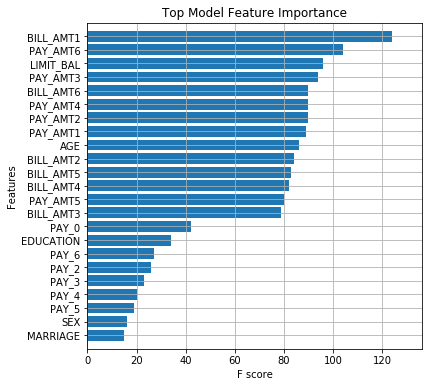

In [28]:
utilsspec.plot_features(model, columns =newcolorder, feature_names=newcolorder)

# Model Deployment and Monitoring

In this notebook, we demonstrate how to manually deploy a DevOps workflow from taking the model we trained in the previous notebook and deploying it into production and monitoring the model endpoint. 

## Batch Transform

Let's first use Batch Transform to run through inference for the test dataset. 

In [29]:
test_full.head()

,Label,PAY_AMT1,BILL_AMT1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,...,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,-0.341476,0.201175,20000.0,1.0,1.0,2.0,33.0,1.0,2.0,...,17399.0,19057.0,18453.0,19755.0,19288.0,2260.0,0.0,1600.0,0.0,644.0
1,0,-0.136859,0.199594,20000.0,2.0,2.0,2.0,35.0,0.0,0.0,...,19347.0,18600.0,19000.0,19000.0,20000.0,0.0,1000.0,0.0,1000.0,0.0
2,0,-0.284364,0.185736,230000.0,2.0,1.0,1.0,44.0,1.0,-1.0,...,949.0,2864.0,933.0,0.0,0.0,2873.0,933.0,0.0,0.0,0.0
3,0,-0.040569,0.289360,100000.0,1.0,2.0,1.0,42.0,0.0,0.0,...,99998.0,16138.0,17758.0,18774.0,20272.0,2000.0,2000.0,2000.0,2000.0,2000.0
4,0,0.079132,0.186502,150000.0,1.0,1.0,2.0,29.0,-2.0,-2.0,...,6917.0,831.0,6469.0,5138.0,7810.0,833.0,6488.0,5153.0,7833.0,7130.0


In [30]:
test_data_no_label = test_full.drop(columns = ['Label'], axis=1)
label = test_full['Label']
test_data_no_label.to_csv('test_data_no_label.csv', index=False, header=False)
test_data_no_label.shape

(6000, 23)

In [31]:
test_data_nohead_location = sess.upload_data('test_data_no_label.csv', bucket=rawbucket, key_prefix=testdatanolabelprefix)

In [32]:
%%time

sm_transformer = xgb.transformer(1, 'ml.m5.xlarge', accept = 'text/csv')

# start a transform job
sm_transformer.transform(test_data_nohead_location, split_type='Line', content_type='text/csv',
                        experiment_config={
            "TrialName": cc_trial.trial_name, #log training job in Trials for lineage
            "TrialComponentDisplayName": "Batch-Transform", #"Training",
        })
sm_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2020-11-03-21-40-55-099
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2020-11-03-21-40-55-548


.............................2020/11/03 21:45:36 [crit] 15#15: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 169.254.255.130, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "169.254.255.131:8080"
169.254.255.130 - - [03/Nov/2020:21:45:36 +0000] "GET /ping HTTP/1.1" 502 182 "-" "Go-http-client/1.1"
2020/11/03 21:45:36 [crit] 15#15: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 169.254.255.130, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "169.254.255.131:8080"
169.254.255.130 - - [03/Nov/2020:21:45:36 +0000] "GET /ping HTTP/1.1" 502 182 "-" "Go-http-client/1.1"
[2020-11-03 21:45:36 +0000] [13] [INFO] Starting gunicorn 19.10.0
[2020-11-03 21:45:36 +0000] [13] [INFO] Listening at: unix:/tmp/gunicorn.sock (13)
[2020-11-03 21:45:36 +0000] [13] [INFO] Us

In [33]:
import json
import io
from urllib.parse import urlparse

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')

In [34]:
output = get_csv_output_from_s3(sm_transformer.output_path, 'test_data_no_label.csv.out')
output_df = pd.read_csv(io.StringIO(output), sep=",", header=None)
output_df.head(8)

,0
0,0.583797
1,0.324310
2,0.240347
3,0.062802
4,0.084180
5,0.510872
6,0.088809
7,0.181571


In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [36]:
output_df['result'] = np.round(output_df[0])

In [37]:
print("Baseline Accuracy = {}".format(1- np.unique(data['Label'], return_counts=True)[1][1]/(len(data['Label']))))
print("Accuracy Score = {}".format(accuracy_score(label, output_df['result'])))

Baseline Accuracy = 0.7787999999999999
Accuracy Score = 0.8236666666666667


In [38]:
output_df['Predicted']=output_df['result'].values
output_df['Label'] = label
confusion_matrix = pd.crosstab(output_df['Predicted'], output_df['Label'], rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix

Predicted,0,1,All
Actual,,,
0.0,4460,815,5275
1.0,243,482,725
All,4703,1297,6000


## Model Deployment as Hosted Endpoint

In [39]:
# Import Model Monitor API
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.predictor import RealTimePredictor
from sagemaker.predictor import csv_serializer

In [40]:
s3_capture_upload_path = 's3://{}/{}/monitoring/datacapture'.format(rawbucket, prefix)

data_capture_configuration = DataCaptureConfig(enable_capture =True,                                          
                                               sampling_percentage=100,
                                               destination_s3_uri=s3_capture_upload_path,
                                             capture_options=["Input", "Output"],
                                            csv_content_types= ["text/csv"],
                                            json_content_types= ["application/json"])

In [41]:
xgb.deploy(1, 'ml.m4.xlarge', data_capture_config=data_capture_configuration)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2020-11-03-21-49-10-039
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2020-11-03-21-49-10-039


-------------------!

### View the captured data and test data capture process

In [44]:
endpoint_name = sm.list_endpoints(
    MaxResults=1,
    SortBy='CreationTime',
    SortOrder='Descending')['Endpoints'][0]['EndpointName']

In [46]:
client = boto3.client('sagemaker-runtime')
endpoint_name = endpoint_name #replace with your endpoint name


!head -10 test_data.csv > test_sample.csv

with open('test_sample.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        response = client.invoke_endpoint(
        EndpointName= endpoint_name,
        Body= payload[2:],
        ContentType = 'text/csv')
        sleep(0.5)
print('done!')

done!


In [47]:
# Extract the captured json files.
data_capture_prefix = '{}/monitoring/datacapture'.format(prefix)
s3_client = boto3.Session().client('s3')
current_endpoint_capture_prefix = '{}/{}/AllTraffic'.format(data_capture_prefix, endpoint_name)
result = s3_client.list_objects(Bucket=rawbucket, Prefix=current_endpoint_capture_prefix)
capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]
print("Found Capture Files:")
print("\n ".join(capture_files))

capture_files[0]

Found Capture Files:
sagemaker-modelmonitor-stefan/monitoring/datacapture/sagemaker-xgboost-2020-11-03-21-49-10-039/AllTraffic/2020/11/03/22/08-18-965-90a583fc-1bcc-41f5-8ecd-d3921d26cf36.jsonl


'sagemaker-modelmonitor-stefan/monitoring/datacapture/sagemaker-xgboost-2020-11-03-21-49-10-039/AllTraffic/2020/11/03/22/08-18-965-90a583fc-1bcc-41f5-8ecd-d3921d26cf36.jsonl'

In [48]:
# View contents of the captured file.
def get_obj_body(bucket, obj_key):
    return s3_client.get_object(Bucket=rawbucket, Key=obj_key).get('Body').read().decode("utf-8")

capture_file = get_obj_body(rawbucket, capture_files[-1])
print(json.dumps(json.loads(capture_file.split('\n')[5]), indent = 2, sort_keys =True))


{
  "captureData": {
    "endpointInput": {
      "data": "-0.34147611300851444,0.1932005252116958,50000.0,1.0,2.0,2.0,25.0,-1.0,3.0,2.0,0.0,0.0,0.0,10386.0,9993.0,9993.0,15300.0,0.0,0.0,200.0,5307.0,0.0,0.0",
      "encoding": "CSV",
      "mode": "INPUT",
      "observedContentType": "text/csv"
    },
    "endpointOutput": {
      "data": "0.5108723044395447",
      "encoding": "CSV",
      "mode": "OUTPUT",
      "observedContentType": "text/csv; charset=utf-8"
    }
  },
  "eventMetadata": {
    "eventId": "fef401ac-6223-4e2f-a245-804e14053fcc",
    "inferenceTime": "2020-11-03T22:08:21Z"
  },
  "eventVersion": "0"
}


## 7 Real time Model monitoring

In [49]:
# copy over the training dataset to Amazon S3 (if you already have it in Amazon S3, you could reuse it).
# Everything is logged in a separate bucket -- that devs who deploy models should be able to access but not necessarily
# data science teams.

# The model bucket can be used to make API calls to the captured Monitoring artifacts. Can also be used to log
# Monitoring calls made for that model.

model_prefix = prefix + "/" + endpoint_name
baseline_prefix = model_prefix + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(rawbucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(rawbucket, baseline_results_prefix)
print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))


Baseline data uri: s3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/sagemaker-xgboost-2020-11-03-21-49-10-039/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/sagemaker-xgboost-2020-11-03-21-49-10-039/baselining/results


In [50]:
train_data_header_location = "s3://" + rawbucket + '/' + prefix + '/train_headers'
print(train_data_header_location)

s3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/train_headers


### Start a baselining job

In [51]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600)

my_default_monitor.suggest_baseline(
    baseline_dataset=os.path.join(train_data_header_location, 'train_data_with_headers.csv'),
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2020-11-03-22-09-55-558



Job Name:  baseline-suggestion-job-2020-11-03-22-09-55-558
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/train_headers/train_data_with_headers.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/sagemaker-xgboost-2020-11-03-21-49-10-039/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.........................2020-11-03 22:13:54,164 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-1:544194174732:processing-job/baseline-suggestion-job-2020-11-03-22-09-55-558', 'ProcessingJobName': 'baseline-suggestion-job-2020-11-03-22-09-55-558', 'Environment':

In [52]:
s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=rawbucket, Prefix=baseline_results_prefix)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Files:")
print("\n ".join(report_files))

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df

Found Files:
sagemaker-modelmonitor-stefan/sagemaker-xgboost-2020-11-03-21-49-10-039/baselining/results/constraints.json
 sagemaker-modelmonitor-stefan/sagemaker-xgboost-2020-11-03-21-49-10-039/baselining/results/statistics.json


,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data,string_statistics.common.num_present,string_statistics.common.num_missing,string_statistics.distinct_count
0,Label,Integral,24000.0,0.0,0.222458,5.339000e+03,0.415897,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN,NaN
1,PAY_AMT1,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24000.0,0.0,6922.0
2,BILL_AMT1,Fractional,24000.0,0.0,0.237809,5.707419e+03,0.080585,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.0999999...",0.64,2048.0,"[[0.19552189076210494, 0.2369590330493186, 0.4...",NaN,NaN,NaN
3,LIMIT_BAL,Fractional,24000.0,0.0,167730.986667,4.025544e+09,129479.698677,10000.0,800000.0,"[{'lower_bound': 10000.0, 'upper_bound': 89000...",0.64,2048.0,"[[30000.0, 120000.0, 200000.0, 130000.0, 28000...",NaN,NaN,NaN
4,SEX,Fractional,24000.0,0.0,1.601167,3.842800e+04,0.489658,1.0,2.0,"[{'lower_bound': 1.0, 'upper_bound': 1.1, 'cou...",0.64,2048.0,"[[1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0,...",NaN,NaN,NaN
5,EDUCATION,Fractional,24000.0,0.0,1.851083,4.442600e+04,0.788030,0.0,6.0,"[{'lower_bound': 0.0, 'upper_bound': 0.6, 'cou...",0.64,2048.0,"[[2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0,...",NaN,NaN,NaN
6,MARRIAGE,Fractional,24000.0,0.0,1.553125,3.727500e+04,0.521227,0.0,3.0,"[{'lower_bound': 0.0, 'upper_bound': 0.3, 'cou...",0.64,2048.0,"[[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0,...",NaN,NaN,NaN
7,AGE,Fractional,24000.0,0.0,35.459542,8.510290e+05,9.191179,21.0,79.0,"[{'lower_bound': 21.0, 'upper_bound': 26.8, 'c...",0.64,2048.0,"[[26.0, 27.0, 58.0, 29.0, 49.0, 23.0, 26.0, 29...",NaN,NaN,NaN
8,PAY_0,Fractional,24000.0,0.0,-0.013167,-3.160000e+02,1.127531,-2.0,8.0,"[{'lower_bound': -2.0, 'upper_bound': -1.0, 'c...",0.64,2048.0,"[[-1.0, 0.0, 1.0, 0.0, -2.0, -1.0, -1.0, 0.0, ...",NaN,NaN,NaN
9,PAY_2,Fractional,24000.0,0.0,-0.127667,-3.064000e+03,1.199702,-2.0,7.0,"[{'lower_bound': -2.0, 'upper_bound': -1.1, 'c...",0.64,2048.0,"[[0.0, 0.0, 2.0, 0.0, -2.0, -1.0, 0.0, 0.0, 5....",NaN,NaN,NaN


In [53]:
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df

  """Entry point for launching an IPython kernel.



,name,inferred_type,completeness,num_constraints.is_non_negative
0,Label,Integral,1.0,True
1,PAY_AMT1,String,1.0,NaN
2,BILL_AMT1,Fractional,1.0,True
3,LIMIT_BAL,Fractional,1.0,True
4,SEX,Fractional,1.0,True
5,EDUCATION,Fractional,1.0,True
6,MARRIAGE,Fractional,1.0,True
7,AGE,Fractional,1.0,True
8,PAY_0,Fractional,1.0,False
9,PAY_2,Fractional,1.0,False


### Create a Monitoring Schedule

In [54]:
code_prefix = '{}/code'.format(prefix)
reports_prefix = '{}/reports'.format(prefix)
s3_report_path = 's3://{}/{}'.format(rawbucket,reports_prefix)
print(s3_report_path)

s3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/reports


In [55]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = 'BYO-xgb-credit-score-model-monitor-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=endpoint_name,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,

)


INFO:sagemaker:Creating monitoring schedule name BYO-xgb-credit-score-model-monitor-schedule-2020-11-03-22-17-21.



Creating Monitoring Schedule with name: BYO-xgb-credit-score-model-monitor-schedule-2020-11-03-22-17-21


### Generate artificial traffic for demo purposes

In [56]:
# load the test dataset sample
test_sample = pd.read_csv('test_sample.csv', names = ['Label'] +['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
)
test_sample.head()

,Label,PAY_AMT1,BILL_AMT1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,...,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,-0.341476,0.201175,20000.0,1.0,1.0,2.0,33.0,1.0,2.0,...,17399.0,19057.0,18453.0,19755.0,19288.0,2260.0,0.0,1600.0,0.0,644.0
1,0,-0.136859,0.199594,20000.0,2.0,2.0,2.0,35.0,0.0,0.0,...,19347.0,18600.0,19000.0,19000.0,20000.0,0.0,1000.0,0.0,1000.0,0.0
2,0,-0.284364,0.185736,230000.0,2.0,1.0,1.0,44.0,1.0,-1.0,...,949.0,2864.0,933.0,0.0,0.0,2873.0,933.0,0.0,0.0,0.0
3,0,-0.040569,0.289360,100000.0,1.0,2.0,1.0,42.0,0.0,0.0,...,99998.0,16138.0,17758.0,18774.0,20272.0,2000.0,2000.0,2000.0,2000.0,2000.0
4,0,0.079132,0.186502,150000.0,1.0,1.0,2.0,29.0,-2.0,-2.0,...,6917.0,831.0,6469.0,5138.0,7810.0,833.0,6488.0,5153.0,7833.0,7130.0


In [57]:
#Store the test data with one column randomly having negative values for Marriage, reduce overall age and change the scale for the Bill amount
faketestdata = test_sample
faketestdata['MARRIAGE'] = -faketestdata['MARRIAGE'].astype(float)
faketestdata['AGE'] = (faketestdata['AGE'] - 10).astype(float)
faketestdata['BILL_AMT2'] = (faketestdata['BILL_AMT2']//10).astype(float)

faketestdata.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Label,PAY_AMT1,BILL_AMT1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,...,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,-0.341476,0.201175,20000.0,1.0,1.0,-2.0,23.0,1.0,2.0,...,1739.0,19057.0,18453.0,19755.0,19288.0,2260.0,0.0,1600.0,0.0,644.0
1,0,-0.136859,0.199594,20000.0,2.0,2.0,-2.0,25.0,0.0,0.0,...,1934.0,18600.0,19000.0,19000.0,20000.0,0.0,1000.0,0.0,1000.0,0.0
2,0,-0.284364,0.185736,230000.0,2.0,1.0,-1.0,34.0,1.0,-1.0,...,94.0,2864.0,933.0,0.0,0.0,2873.0,933.0,0.0,0.0,0.0
3,0,-0.040569,0.289360,100000.0,1.0,2.0,-1.0,32.0,0.0,0.0,...,9999.0,16138.0,17758.0,18774.0,20272.0,2000.0,2000.0,2000.0,2000.0,2000.0
4,0,0.079132,0.186502,150000.0,1.0,1.0,-2.0,19.0,-2.0,-2.0,...,691.0,831.0,6469.0,5138.0,7810.0,833.0,6488.0,5153.0,7833.0,7130.0


In [58]:
# save the dataset
faketestdata.drop(columns=['Label']).to_csv('test-data-input-cols.csv', index = None, header=None)

In [60]:
from threading import Thread

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                          ContentType='text/csv', 
                                          Body=payload)
            time.sleep(1)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint_name, 'test-data-input-cols.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()
# Note that you need to stop the kernel to stop the invocations

In [61]:
desc_schedule_result = my_default_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

Schedule status: Scheduled


### List Model Monitor Outputs

This process will take time as the Model Monitoring will run an execution every hour or so. It may take up to 20 mins for the first execution to run and an output to be visible in the APIs below.

In [64]:
mon_executions = my_default_monitor.list_executions()
print("We created ahourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(600)
    mon_executions = my_default_monitor.list_executions()

We created ahourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer.
We will have to wait till we hit the hour...


Once the Monitoring job is complete, you should see a json formatted output like here:


{'ProcessingInputs': [{'InputName': 'input_1',
   'S3Input': {'S3Uri': 's3://{}/sagemaker-modelmonitor/monitoring/datacapture/cc-training-job-1585663797/AllTraffic/2020/03/31/14',
    'LocalPath': '/opt/ml/processing/input/endpoint/cc-training-job-1585663797/AllTraffic/2020/03/31/14',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'baseline',
   'S3Input': {'S3Uri': 's3://{}/sagemaker-modelmonitor/cc-training-job-1585663797/baselining/results/statistics.json',
    'LocalPath': '/opt/ml/processing/baseline/stats',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}},
  {'InputName': 'constraints',
   'S3Input': {'S3Uri': 's3://{}/sagemaker-modelmonitor/cc-training-job-1585663797/baselining/results/constraints.json',
    'LocalPath': '/opt/ml/processing/baseline/constraints',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output': {'S3Uri': 's3://{}/sagemaker-modelmonitor/reports/cc-training-job-1585663797/BYO-xgb-credit-score-model-monitor-schedule-2020-03-31-14-54-12/2020/03/31/15',
     'LocalPath': '/opt/ml/processing/output',
     'S3UploadMode': 'Continuous'}}]},
 'ProcessingJobName': 'model-monitoring-202003311500-0571748e9969313bbe1b3bfd',
 'ProcessingResources': {'ClusterConfig': {'InstanceCount': 1,
   'InstanceType': 'ml.m5.xlarge',
   'VolumeSizeInGB': 20}},
 'StoppingCondition': {'MaxRuntimeInSeconds': 3600},
 'AppSpecification': {'ImageUri': '777275614652.dkr.ecr.us-east-2.amazonaws.com/sagemaker-model-monitor-analyzer'},
 'Environment': {'baseline_constraints': '/opt/ml/processing/baseline/constraints/constraints.json',
  'baseline_statistics': '/opt/ml/processing/baseline/stats/statistics.json',
  'dataset_format': '{"sagemakerCaptureJson":{"captureIndexNames":["endpointOutput","endpointInput"]}}',
  'dataset_source': '/opt/ml/processing/input/endpoint',
  'end_time': '2020-03-31T15:00:00Z',
  'output_path': '/opt/ml/processing/output',
  'publish_cloudwatch_metrics': 'Enabled',
  'sagemaker_endpoint_name': 'cc-training-job-1585663797',
  'sagemaker_monitoring_schedule_name': 'BYO-xgb-credit-score-model-monitor-schedule-2020-03-31-14-54-12',
  'start_time': '2020-03-31T14:00:00Z'},
 'RoleArn': '{}',
 'ProcessingJobArn': 'arn:aws:sagemaker:{}:processing-job/model-monitoring-202003311500-0571748e9969313bbe1b3bfd',
 'ProcessingJobStatus': 'InProgress',
 'ProcessingStartTime': datetime.datetime(2020, 3, 31, 15, 11, 28, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2020, 3, 31, 15, 11, 28, 408000, tzinfo=tzlocal()),
 'CreationTime': datetime.datetime(2020, 3, 31, 15, 8, 24, 255000, tzinfo=tzlocal()),
 'MonitoringScheduleArn': 'arn:aws:sagemaker:{}:monitoring-schedule/byo-xgb-credit-score-model-monitor-schedule-2020-03-31-14-54-12',
 'ResponseMetadata': {'RequestId': 'c224933e-0c1d-4b1a-a63b-42f3b45833a4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c224933e-0c1d-4b1a-a63b-42f3b45833a4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2884',
   'date': 'Tue, 31 Mar 2020 15:12:01 GMT'},
  'RetryAttempts': 0}}

In [65]:
mon_executions[-1].describe()

{'ProcessingInputs': [{'InputName': 'input_1',
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/monitoring/datacapture/sagemaker-xgboost-2020-11-03-21-49-10-039/AllTraffic/2020/11/04/16',
    'LocalPath': '/opt/ml/processing/input/endpoint/sagemaker-xgboost-2020-11-03-21-49-10-039/AllTraffic/2020/11/04/16',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'baseline',
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/sagemaker-xgboost-2020-11-03-21-49-10-039/baselining/results/statistics.json',
    'LocalPath': '/opt/ml/processing/baseline/stats',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}},
  {'InputName': 'constraints',
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/sagemaker-xgboost-20

### Inspect the latest execution and generate a report.

All the API calls used here can be implemented separately using API Gateway or other tools. ModelMonitor can also be set up to send alerts and notifications through CloudWatch whenever drift is detected.

In [67]:
latest_execution = mon_executions[-1] # latest execution's index is -1, second to last is -2 and so on..
time.sleep(60)
latest_execution.wait(logs=False)

print("Latest execution status: {}".format(latest_execution.describe()['ProcessingJobStatus']))
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))

latest_job = latest_execution.describe()
if (latest_job['ProcessingJobStatus'] != 'Completed'):
        print("====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures.")

!Latest execution status: Completed
Latest execution result: CompletedWithViolations: Job completed successfully with 4 violations.


In [68]:
report_uri=latest_execution.output.destination
print('Report Uri: {}'.format(report_uri))

Report Uri: s3://sagemaker-us-east-1-544194174732/sagemaker-modelmonitor-stefan/reports/sagemaker-xgboost-2020-11-03-21-49-10-039/BYO-xgb-credit-score-model-monitor-schedule-2020-11-03-22-17-21/2020/11/04/16


In [69]:
from urllib.parse import urlparse
s3uri = urlparse(report_uri)
report_bucket = s3uri.netloc
report_key = s3uri.path.lstrip('/')
print('Report bucket: {}'.format(report_bucket))
print('Report key: {}'.format(report_key))

s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=rawbucket, Prefix=report_key)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Report Files:")
print("\n ".join(report_files))

Report bucket: sagemaker-us-east-1-544194174732
Report key: sagemaker-modelmonitor-stefan/reports/sagemaker-xgboost-2020-11-03-21-49-10-039/BYO-xgb-credit-score-model-monitor-schedule-2020-11-03-22-17-21/2020/11/04/16
Found Report Files:
sagemaker-modelmonitor-stefan/reports/sagemaker-xgboost-2020-11-03-21-49-10-039/BYO-xgb-credit-score-model-monitor-schedule-2020-11-03-22-17-21/2020/11/04/16/constraint_violations.json
 sagemaker-modelmonitor-stefan/reports/sagemaker-xgboost-2020-11-03-21-49-10-039/BYO-xgb-credit-score-model-monitor-schedule-2020-11-03-22-17-21/2020/11/04/16/constraints.json
 sagemaker-modelmonitor-stefan/reports/sagemaker-xgboost-2020-11-03-21-49-10-039/BYO-xgb-credit-score-model-monitor-schedule-2020-11-03-22-17-21/2020/11/04/16/statistics.json


In [70]:
pd.set_option('display.max_colwidth', -1)
violations = my_default_monitor.latest_monitoring_constraint_violations()
#pd.set_option('display.max_colwidth', -1)
violations_df = pd.io.json.json_normalize(violations.body_dict["violations"])
violations_df

  """Entry point for launching an IPython kernel.

  after removing the cwd from sys.path.



,feature_name,constraint_check_type,description
0,PAY_AMT1,data_type_check,"Data type match requirement is not met. Expected data type: String, Expected match: 100.0%. Observed: Only 0.0% of data is String."
1,Label,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 0.0% of data is Integral."
2,AGE,baseline_drift_check,Baseline drift distance: 0.27281598882896196 exceeds threshold: 0.1
3,BILL_AMT2,baseline_drift_check,Baseline drift distance: 0.2971446416440181 exceeds threshold: 0.1


# Delete Underlying Resources and Monitoring Jobs (optional)

For this demo: once you are done monitoring your jobs, be sure to delete the endpoint to avoid incurring costs. 

In [71]:
my_default_monitor.delete_monitoring_schedule()
time.sleep(10) # actually wait for the deletion


Deleting Monitoring Schedule with name: BYO-xgb-credit-score-model-monitor-schedule-2020-11-03-22-17-21


In [72]:
sm.delete_endpoint(EndpointName =endpoint_name)

{'ResponseMetadata': {'RequestId': 'b5f812d5-8da0-4140-b709-9cab5fbb08b2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b5f812d5-8da0-4140-b709-9cab5fbb08b2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 04 Nov 2020 18:02:09 GMT'},
  'RetryAttempts': 0}}

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-60-348af152e8b1>", line 17, in invoke_endpoint_forever
    invoke_endpoint(endpoint_name, 'test-data-input-cols.csv', runtime_client)
  File "<ipython-input-60-348af152e8b1>", line 12, in invoke_endpoint
    Body=payload)
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 357, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 676, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint sagemaker-xgboost-2020-11-03-21-49-10-039 of account 544194174